In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

In [10]:
#To show the data in Measurement table
inspector=inspect(engine)

Measurement_table=inspector.get_columns("Measurement")
print("Measurement_table:")
for column in Measurement_table:
    print(column["name"], column["type"])


Measurement_table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
##To show the data in Station table
Stationt_table=inspector.get_columns("Station")
print("Station_table:")
for column in Stationt_table:
    print(column["name"], column["type"])

Station_table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"This is the last date {last_date[0]}")
last_year_ago=(dt.datetime.strptime(last_date[0],'%Y-%m-%d')- dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"The date 1 year ago from the last date is {last_year_ago}")

This is the last date 2017-08-23
The date 1 year ago from the last date is 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
Measurement_column=(Measurement.date, Measurement.prcp)
precipitation_data=session.query(*Measurement_column).filter(Measurement.date >= last_year_ago).all()
precipitation_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame 
precipitation_df=pd.DataFrame(precipitation_data, columns=["date", "precipitation"])
#and set the index to the date column
precipitation_df.set_index("date", inplace = True)

# Sort the dataframe by date
precipitation_df=precipitation_df.sort_index()


Text(0, 0.5, 'Precepitation level')

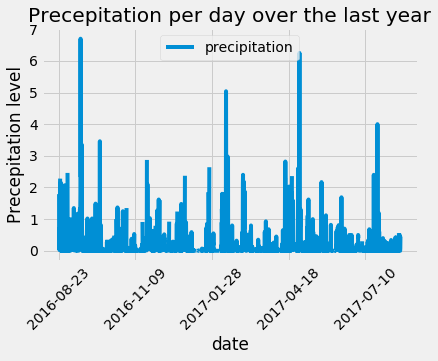

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plot=precipitation_df.plot(rot=45)
plot.set_title("Precepitation per day over the last year")
plot.set_ylabel("Precepitation level")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
Total_Station=session.query(func.count(Station.id)).all()
Total_Station

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station=='USC00519281').\
filter(Measurement.date >= last_year_ago).all()

[(59.0, 83.0, 73.10795454545455)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
USC00519281_data=session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station=='USC00519281').\
filter(Measurement.date >= last_year_ago).all()
USC00519281_data[:5]


[('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0)]

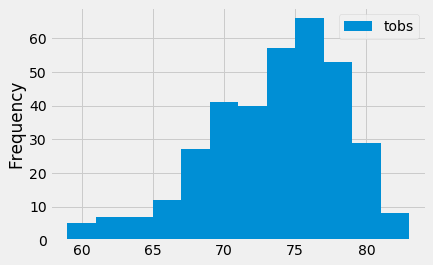

In [21]:
# plot the results as a histogram
USC00519281_df=pd.DataFrame(USC00519281_data, columns=["station", "tobs"])
USC00519281_df.head()
USC00519281_df.plot(kind="hist", bins=12);


## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
temp=calc_temps('2016-08-23', '2017-08-23')
temp

[(58.0, 74.59058295964125, 87.0)]

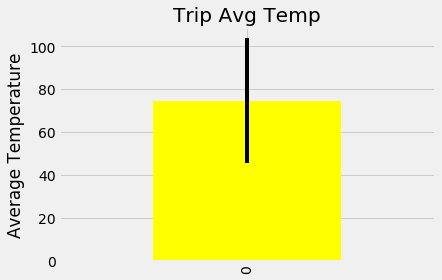

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_df=pd.DataFrame(temp, columns=["tmin", "tavg", "tmax"])
temp_df
ax=temp_df["tavg"].plot.bar(yerr=(temp_df["tmax"])-(temp_df["tmin"]), color="yellow")
plt.title("Trip Avg Temp")
plt.ylabel("Average Temperature")
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#need to join both table
start_date="2016-08-23"
end_date="2017-08-23"
column_list=[Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]
total_rainfall=session.query(*column_list).group_by(Measurement.station).\
outerjoin(Station, Measurement.station==Station.station).\
filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).\
order_by(func.sum(Measurement.tobs).desc()).all()
total_rainfall
total_rainfall_df=pd.DataFrame(total_rainfall, columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)
total_rainfall_df.head()

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",27151.0,21.27160,-157.81680,3.0
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",25939.0,21.33556,-157.71139,19.5
2,USC00519281,"WAIHEE 837.5, HI US",25734.0,21.45167,-157.84889,32.9
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",25160.0,21.33310,-157.80250,152.4
4,USC00513117,"KANEOHE 838.1, HI US",25134.0,21.42340,-157.80150,14.6


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trp_start_date = "2020-09-01"
trp_end_date = "2020-09-15"
# Use the start and end date to create a range of dates
start_date_r=dt.datetime.strptime(trp_start_date, "%Y-%m-%d")
end_date_r=dt.datetime.strptime(trp_end_date, "%Y-%m-%d")
delta=end_date_r-start_date_r
normals=[]
for i in range(delta.days + 1):
    day=start_date_r + dt.timedelta(days=i)
# Stip off the year and save a list of %m-%d strings
    month_and_day=dt.datetime.strftime(day, "%m-%d")
    normals.append(month_and_day)
normals

[(69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0),
 (66.0, 74.91111111111111, 81.0),
 (64.0, 75.18, 82.0),
 (66.0, 76.22222222222223, 83.0),
 (68.0, 76.36538461538461, 84.0),
 (67.0, 76.61224489795919, 85.0),
 (70.0, 76.69565217391305, 83.0),
 (68.0, 75.89795918367346, 85.0),
 (68.0, 75.875, 82.0),
 (69.0, 75.98076923076923, 85.0),
 (67.0, 76.14, 81.0)]

In [ ]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list=[]
for day in normals:
    normal_list.append(daily_normals(day)[0])
normal_list

In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal_df=pd.DataFrame(normal_list,columns=["tmin","tavg","tmax"],index=[normals])
normal_df.index = normal_df.index.get_level_values(0)
daily_normal_df

,tmin,tavg,tmax
09-01,69.0,77.000000,82.0
09-02,67.0,76.666667,83.0
09-03,69.0,76.137255,83.0
09-04,68.0,76.270833,84.0
09-05,66.0,75.914894,84.0
09-06,66.0,74.911111,81.0
09-07,64.0,75.180000,82.0
09-08,66.0,76.222222,83.0
09-09,68.0,76.365385,84.0
09-10,67.0,76.612245,85.0


Text(0.5, 0, 'date')

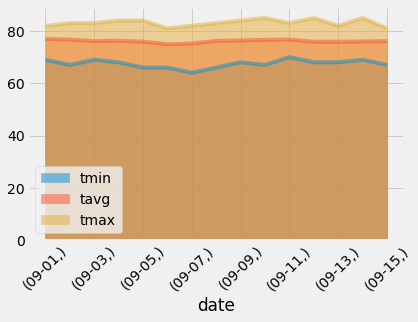

In [51]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normal_df.plot(kind="area",stacked=False,rot=45)
plt.xlabel("date")